# Setup

In [1]:
#GPU runtime required, should give CUDA version
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!cp -r /content/gdrive/MyDrive/Explainable_Wound_Classification/CMSF/self_supervised/* /content
!cp -r /content/gdrive/MyDrive/Explainable_Wound_Classification/RISE/* /content
root_path = 'gdrive/MyDrive/Explainable_Wound_Classification/'

In [4]:
!pip install faiss-gpu
!pip install fuzzy-c-means
!pip install lime

     |████████████████████████████████| 85.5 MB 111 kB/s 
     |████████████████████████████████| 10.9 MB 8.7 MB/s 
     |████████████████████████████████| 275 kB 8.5 MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=ce6004e5f79b761d670278cef4e799efd22686821877b65f4d9c56b2105e1f9d
  Stored in directory: /root/.cache/pip/wheels/ca/cb/e5/ac701e12d365a08917bf4c6171c0961bc880a8181359c66aa7
Successfully built lime


In [67]:
import builtins
import os
import sys
import time
import argparse
import random
import copy
from collections import Counter, OrderedDict
from random import shuffle

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torchvision import transforms, datasets, models

from PIL import ImageFilter, Image
from util import adjust_learning_rate, AverageMeter as AvgMeter, subset_classes

import pdb
import faiss
from fcmeans import FCM

import numpy as np
from scipy import stats
import pandas as pd
import re
from collections import namedtuple
import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

import shutil
import warnings

import torch.nn.parallel
import torch.optim
import torch.utils.data
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms.functional as TF

from tools import *

from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.cm as mpl_color_map

from tqdm import tqdm
from utils import *
from explanations import RISE

#CMSF-KM

### Misc Functions

In [6]:
def get_mlp(inp_dim, hidden_dim, out_dim):
    mlp = nn.Sequential(
        nn.Linear(inp_dim, hidden_dim),
        nn.BatchNorm1d(hidden_dim),
        nn.ReLU(inplace=True),
        nn.Linear(hidden_dim, out_dim),
    )
    return mlp

In [7]:
def set_parameter_requires_grad(model, requires_grad=False):
    for param in model.parameters():
        param.requires_grad = requires_grad

In [8]:
def faiss_kmeans(feats, nmb_clusters):
    feats = feats.numpy()
    d = feats.shape[-1]
    clus = faiss.Clustering(d, nmb_clusters)
    clus.niter = 20
    clus.max_points_per_centroid = 10000000

    index = faiss.IndexFlatL2(d)
    co = faiss.GpuMultipleClonerOptions()
    co.useFloat16 = True
    co.shard = True
    index = faiss.index_cpu_to_all_gpus(index, co)

    # perform the training
    clus.train(feats, index)
    _, train_a = index.search(feats, 1)

    return list(train_a[:, 0])

In [9]:
def fuzzy_c_means(feats, nmb_clusters):
    feats = feats.numpy()
    
    fcm = FCM(n_clusters=nmb_clusters)
    fcm.fit(feats)

    return fcm.predict(feats), fcm

In [10]:
def get_shuffle_ids(bsz):
    """generate shuffle ids for ShuffleBN"""
    forward_inds = torch.randperm(bsz).long().cuda()
    backward_inds = torch.zeros(bsz).long().cuda()
    value = torch.arange(bsz).long().cuda()
    backward_inds.index_copy_(0, forward_inds, value)
    return forward_inds, backward_inds


### Model Architecture

In [11]:
# HealNet Encoder
class Encoder(nn.Module):
    """
    Encoder model Pytorch. 
    """   
    def __init__(self):
        # Initialize self._modules as OrderedDict
        super(Encoder, self).__init__() 
        # Initialize densenet121
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=False)
        # Remove Classifying layer
        self.embed_model = nn.Sequential(*list(self.embed_model.children())[:-1])
        # 7x7 average pool layer
        self.avg = nn.AvgPool2d(kernel_size=7, stride=1)
        # Left image connected layers
        self.fc_16 = nn.Linear(1024, 16)


    def forward(self, x):
        # Embed Left
        u1 = self.embed_model(x)
        u1 = self.avg(u1)
        u1 = u1.view(-1,1024)
        u1 = self.fc_16(u1)
        #u1 = torch.relu(u1)
        return u1

In [12]:
# Healnet ecnoder with resnet
class ResnetEncoder(nn.Module):
    """
    ResnetEncoder model Pytorch. 
    """   
    def __init__(self):
        # Initialize self._modules as OrderedDict
        super(ResnetEncoder, self).__init__() 
        # Initialize resnet18
        self.embed_model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
        # Classification Layer
        num_ftrs = self.embed_model.fc.in_features
        self.embed_model.fc = nn.Linear(num_ftrs, 16)
        self.fc = self.embed_model.fc


    def forward(self, x):
        # Embed Left
        return self.embed_model(x)

In [13]:
def initialize_encoder(model_name, output_dim, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, output_dim)
        input_size = 224

    elif model_name == "healnet":
        """ Pretrained Encoder from HealNet
        """
        model_ft = Encoder()
        model_ft.load_state_dict(torch.load(root_path + 'trained_encoder_weights.tar'))
        set_parameter_requires_grad(model_ft)
        set_parameter_requires_grad(model_ft.fc_16, requires_grad=True)
        input_size = 224
    
    elif model_name == "resnet_healnet":
        """ Pretrained Encoder from HealNet
        """
        model_ft = ResnetEncoder()
        model_ft.load_state_dict(torch.load(root_path + 'resnet_healnet_encoder_weights.tar'))
        set_parameter_requires_grad(model_ft)
        set_parameter_requires_grad(model_ft.fc, requires_grad=True)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,output_dim)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,output_dim)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        model_ft.classifier[1] = nn.Conv2d(512, output_dim, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = output_dim
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, output_dim)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, output_dim)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,output_dim)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [14]:
class ConstrainedMeanShiftKM(nn.Module):
    def __init__(self, arch, m=0.99, mem_bank_size=128000, topk=5, dataset_size=100, num_clusters=4, output_dim=16):
        super(ConstrainedMeanShiftKM, self).__init__()

        # save parameters
        self.m = m
        self.mem_bank_size = mem_bank_size
        self.topk = topk
        self.dataset_size = dataset_size
        self.num_clusters = num_clusters

        # create encoders and projection layers
        # both encoders should have same arch
        self.encoder_q = initialize_encoder(arch, output_dim)[0]
        self.encoder_t = initialize_encoder(arch, output_dim)[0]

        # prediction layer
        self.predict_q = get_mlp(output_dim, output_dim * 2, output_dim)

        # copy query encoder weights to target encoder
        for param_q, param_t in zip(self.encoder_q.parameters(), self.encoder_t.parameters()):
            param_t.data.copy_(param_q.data)
            param_t.requires_grad = False

        print("using mem-bank size {}".format(self.mem_bank_size))
        # setup queue (For Storing Random Targets)
        self.register_buffer('queue', torch.randn(self.mem_bank_size, output_dim))
        self.register_buffer('pool', torch.randn(self.dataset_size, output_dim))
        self.register_buffer('pseudo_labels', 0*torch.ones(self.dataset_size).long())
        # normalize the queue embeddings
        self.queue = nn.functional.normalize(self.queue, dim=1)
        # initialize the labels queue (For Purity measurement)
        self.register_buffer('labels', -1*torch.ones(self.mem_bank_size).long())
        self.register_buffer('index_queue', -1 * torch.ones(self.mem_bank_size).long())
        # setup the queue pointer
        self.register_buffer('queue_ptr', torch.zeros(1, dtype=torch.long))

    @torch.no_grad()
    def _momentum_update_target_encoder(self):
        for param_q, param_t in zip(self.encoder_q.parameters(), self.encoder_t.parameters()):
            param_t.data = param_t.data * self.m + param_q.data * (1. - self.m)

    @torch.no_grad()
    def data_parallel(self):
        self.encoder_q = torch.nn.DataParallel(self.encoder_q)
        self.encoder_t = torch.nn.DataParallel(self.encoder_t)
        self.predict_q = torch.nn.DataParallel(self.predict_q)

    @torch.no_grad()
    def cluster(self):
        print('start clustering ... num clusters: {}'.format(self.num_clusters))
        cluster_assignment, cluster_model = fuzzy_c_means(self.pool.clone().cpu(), self.num_clusters)
        self.pseudo_labels = torch.tensor(cluster_assignment).cuda()
        return cluster_model

    @torch.no_grad()
    def _dequeue_and_enqueue(self, targets, labels, indices):
        batch_size = targets.shape[0]

        ptr = int(self.queue_ptr)
        assert self.mem_bank_size % batch_size == 0 

        # replace the targets at ptr (dequeue and enqueue)
        self.pool[indices, :] = targets
        self.queue[ptr:ptr + batch_size] = targets
        self.labels[ptr:ptr + batch_size] = labels
        self.index_queue[ptr:ptr + batch_size] = indices
        ptr = (ptr + batch_size) % self.mem_bank_size  # move pointer

        self.queue_ptr[0] = ptr

    def forward(self, im_q, im_t, labels, indices):
        # compute query features
        feat_q = self.encoder_q(im_q)
        # compute predictions for instance level regression loss
        query = self.predict_q(feat_q)
        query = nn.functional.normalize(query, dim=1)

        # compute target features
        with torch.no_grad():
            # update the target encoder
            self._momentum_update_target_encoder()

            # shuffle targets
            shuffle_ids, reverse_ids = get_shuffle_ids(im_t.shape[0])
            im_t = im_t[shuffle_ids]

            # forward through the target encoder
            current_target = self.encoder_t(im_t)
            current_target = nn.functional.normalize(current_target, dim=1)

            # undo shuffle
            current_target = current_target[reverse_ids].detach()

            # update the memory-bank
            self._dequeue_and_enqueue(current_target, labels, indices)

        targets = self.queue.clone().detach()

        # get pseudo of target and memory bank samples
        current_target_pseudo_labels = self.pseudo_labels[indices]
        targets_pseudo_labels = self.pseudo_labels[self.index_queue]

        # create a mask to constrain the search space
        b = current_target_pseudo_labels.shape[0]
        m = targets_pseudo_labels.shape[0]
        lx = current_target_pseudo_labels.unsqueeze(1).expand((b, m))
        lm = targets_pseudo_labels.unsqueeze(0).expand((b, m))
        msk = lx != lm

        # calculate distances between vectors
        dist_t = 2 - 2 * torch.einsum('bc,kc->bk', [current_target, targets])
        dist_q = 2 - 2 * torch.einsum('bc,kc->bk', [query, targets])

        # select the k nearest neighbors [with smallest distance (largest=False)] based on current target
        _, unconstrained_nn_index = dist_t.topk(self.topk, dim=1, largest=False)

        # select the k nearest neighbors based on constrained memory bank
        dist_t[torch.where(msk)] = 5.0
        _, constrained_nn_index = dist_t.topk(self.topk, dim=1, largest=False)

        # calculate mean shift regression loss
        nn_dist_q_constrained = torch.gather(dist_q, 1, constrained_nn_index)
        nn_dist_q_unconstrained = torch.gather(dist_q, 1, unconstrained_nn_index)

        # purity based on memory bank
        labels = labels.unsqueeze(1).expand(nn_dist_q_unconstrained.shape[0], nn_dist_q_unconstrained.shape[1])
        labels_queue = self.labels.clone().detach()
        labels_queue = labels_queue.unsqueeze(0).expand((nn_dist_q_unconstrained.shape[0], self.mem_bank_size))
        labels_queue = torch.gather(labels_queue, dim=1, index=unconstrained_nn_index)
# TODO: Change matches here
        matches = (labels_queue == labels).float()
        purity = (matches.sum(dim=1) / self.topk).mean()

        loss = ((nn_dist_q_constrained.sum(dim=1) / self.topk).mean()
                + (nn_dist_q_unconstrained.sum(dim=1) / self.topk).mean()) / 2.0

        return loss, purity

### Transformations/Data Loading

In [15]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and target."""
    def __init__(self, weak_transform, strong_transform):
        self.weak_transform = weak_transform
        self.strong_transform = strong_transform
        print(self.weak_transform)
        print(self.strong_transform)

    def __call__(self, x):
        q = self.strong_transform(x)
        t = self.weak_transform(x)
        return [q, t]


class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

In [16]:
class Image_Dataset(torch.utils.data.Dataset):

    def __init__(self, root_dir, label_fn, transform=None):
        """
        Image dataset. Returns tensorized images and labels with index
        Args:
            root_dir: path to a cropped mouse image dataset.
            label_fn: function that returns the correct label given an image name
        """
        self.root_dir = root_dir
        self.label_fn = label_fn
        self.transform = transform

        samples = []
        targets = []
        for f in os.listdir(root_dir):
            samples.append(os.path.join(root_dir, f))
            targets.append(label_fn(f))
        
        self.samples = samples
        self.targets = targets

    def pil_loader(self, path):
        # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
        with open(path, 'rb') as f:
            img = Image.open(f)
            return img.convert('RGB')

    def __getitem__(self, index: int):
            """
            Returns index, tensor data, and tensorized label.
            """
            img = self.pil_loader(self.samples[index])
            target = self.targets[index]

            if self.transform:
                img = self.transform(img)

            return index, img, torch.tensor(target)

    def __len__(self):
        return len(self.samples)

    def __str__(self):
        return "Image_Dataset:\n" + "Found " + str(len(self)) + " images in " + self.root_dir + "\n"

In [17]:
# Create train loader
def get_train_loader(datapath, label_fn, batch_size, num_workers, weak_strong=True):
    traindir = os.path.join(datapath, 'train')
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    normalize = transforms.Normalize(mean=mean, std=std)

    augmentation_strong = [
        transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        #transforms.Resize(224),
        #transforms.RandomApply([
        #    transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        #], p=0.8),
        #transforms.RandomGrayscale(p=0.2),
        #transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
        transforms.RandomHorizontalFlip(),
        #transforms.ColorJitter(saturation=(0,1)),
        transforms.RandomRotation((0, 360)),
        #transforms.RandomAffine((0,0), translate=(0.3, 0.3)),
        transforms.ToTensor(),
        normalize
    ]

    augmentation_weak = [
        #transforms.RandomResizedCrop(224, scale=(0.2, 1.)),
        transforms.Resize(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation((0, 360)),
        transforms.ToTensor(),
        normalize,
    ]

    if weak_strong:
        train_dataset = Image_Dataset(
            traindir, label_fn, 
            TwoCropsTransform(transforms.Compose(augmentation_weak), transforms.Compose(augmentation_strong))
        )
    else:
        train_dataset = Image_Dataset(
            traindir, label_fn, 
            TwoCropsTransform(transforms.Compose(augmentation_strong), transforms.Compose(augmentation_strong))
        )

    print('==> train dataset')
    print(train_dataset)

    # NOTE: remove drop_last
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True, drop_last=True)

    return train_loader

In [18]:
def get_val_loader(datapath, label_fn, num_workers, batch_size=-1, test=False, train=False):
    if test:
        valdir = os.path.join(datapath, 'test')
    elif train:
        valdir = os.path.join(datapath, 'train')
    else:
        valdir = os.path.join(datapath, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    val_transform = transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])

    dataset = Image_Dataset(valdir, label_fn, val_transform)

    if batch_size == -1:
        batch_size = len(dataset)

    val_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True,
    )
    return val_loader, dataset.samples

### Training Functions

In [19]:
def train(epoch, train_loader, mean_shift, optimizer, print_freq):
    """
    one epoch training
    """
    mean_shift.train()

    batch_time = AvgMeter()
    data_time = AvgMeter()
    loss_meter = AvgMeter()
    purity_meter = AvgMeter()

    end = time.time()
    for idx, (indices, (im_q, im_t), labels) in enumerate(train_loader):
        data_time.update(time.time() - end)
        im_q = im_q.cuda(non_blocking=True)
        im_t = im_t.cuda(non_blocking=True)
        labels = labels.cuda(non_blocking=True)

        # ===================forward=====================
        loss, purity = mean_shift(im_q=im_q, im_t=im_t, labels=labels, indices=indices)

        # ===================backward=====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # ===================meters=====================
        loss_meter.update(loss.item(), im_q.size(0))
        purity_meter.update(purity.item(), im_q.size(0))

        torch.cuda.synchronize()
        batch_time.update(time.time() - end)
        end = time.time()

        # print info
        if (idx + 1) % print_freq == 0:
            print('Train: [{0}][{1}/{2}]\t'
                  'BT {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'DT {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'purity {purity.val:.3f} ({purity.avg:.3f})\t'
                  'loss {loss.val:.3f} ({loss.avg:.3f})\t'.format(
                   epoch, idx + 1, len(train_loader), batch_time=batch_time,
                   data_time=data_time,
                   purity=purity_meter,
                   loss=loss_meter))
            sys.stdout.flush()
            sys.stdout.flush()

    

    return loss_meter.avg, purity_meter.avg

In [20]:
#workaround struct to pass args to util script
LRArgs = namedtuple('LRArgs', ['cos', 'learning_rate', 'epochs', 'lr_decay_rate'])

In [21]:
def cmsf_km_main(data_path, checkpoint_path, label_fn, batch_size=16, num_workers=2, 
                 epochs=200, print_freq=10, save_freq=10, weak_strong=True, 
                 debug=False, arch='resnet50', momentum=0.99, mem_bank_size=128000, 
                 topk=5, num_clusters=4, learning_rate=0.05, sgd_momentum=0.9, 
                 weight_decay=1e-4, weights=None, resume=None, cos=True, 
                 lr_decay_rate=0.2, output_dim=16):
    """
    todo: docstring
    """
    opt = locals()
    del opt['label_fn']

    if (not resume):
        os.makedirs(checkpoint_path)

    train_loader = get_train_loader(data_path, label_fn, batch_size, num_workers, weak_strong)

    mean_shift = ConstrainedMeanShiftKM(
        arch,
        m=momentum,
        mem_bank_size=mem_bank_size,
        topk=topk,
        dataset_size=len(train_loader.dataset),
        num_clusters=num_clusters,
        output_dim=output_dim
    )

    mean_shift.data_parallel()
    mean_shift = mean_shift.cuda()
    print(mean_shift)


    print("Params to learn:")
    for name,param in mean_shift.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

    params = [p for p in mean_shift.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params,
                                lr=learning_rate,
                                momentum=sgd_momentum,
                                weight_decay=weight_decay)

    cudnn.benchmark = True
    start_epoch = 1

    history_df = pd.DataFrame(index=range(start_epoch, epochs + 1))

    if weights:
        print('==> load weights from checkpoint: {}'.format(weights))
        ckpt = torch.load(weights)
        print('==> resume from epoch: {}'.format(ckpt['epoch']))
        if 'model' in ckpt:
            sd = ckpt['model']
        else:
            sd = ckpt['state_dict']
        msg = mean_shift.load_state_dict(sd, strict=False)
        optimizer.load_state_dict(ckpt['optimizer'])
        start_epoch = ckpt['epoch'] + 1
        print(msg)
    

    if resume:
        print('==> resume from checkpoint: {}'.format(resume))
        ckpt = torch.load(resume, map_location='cpu')
        # sd = ckpt['state_dict']
        # sd = {k.replace('module.', ''): v for k, v in sd.items()}
        print('==> resume from epoch: {}'.format(ckpt['epoch']))
        mean_shift.load_state_dict(ckpt['state_dict'], strict=True)
        optimizer.load_state_dict(ckpt['optimizer'])
        start_epoch = ckpt['epoch'] + 1
        history_df = ckpt['history_df']

    lr_args = LRArgs(cos, learning_rate, epochs, lr_decay_rate)

    for epoch in range(start_epoch, epochs + 1):

        adjust_learning_rate(epoch, lr_args, optimizer)
        print("==> training...")

        time1 = time.time()

        loss, purity = train(epoch, train_loader, mean_shift, optimizer, print_freq)
        cluster_model = mean_shift.cluster()

        time2 = time.time()
        print('epoch {}, total time {:.2f}'.format(epoch, time2 - time1))

        history_df.loc[epoch, 'loss'] = loss
        history_df.loc[epoch, 'purity'] = purity

        # saving the model
        if epoch % save_freq == 0:
            print('==> Saving...')
            state = {
                'opt': opt,
                'state_dict': mean_shift.state_dict(),
                'optimizer': optimizer.state_dict(),
                'epoch': epoch,
                'history_df': history_df
            }

            save_file = os.path.join(checkpoint_path, 'ckpt_epoch_{epoch}.pth'.format(epoch=epoch))
            torch.save(state, save_file)

            # help release GPU memory
            del state
            torch.cuda.empty_cache()

### Getting Label Assignments

In [255]:
labels_df = pd.read_csv(root_path + 'Cleaned_Wound_Stage_Labels.csv', index_col='Image')
labels_df.head()

,hemostasis,inflammatory,proliferative,maturation,label
Image,,,,,
Day 8_A8-4-L.png,0.181818,0.090909,0.545455,0.181818,2
Day 4_A8-3-R.png,0.090909,0.909091,0.000000,0.000000,1
Day 14_Y8-4-L.png,0.000000,0.000000,0.090909,0.909091,3
Day 7_Y8-4-L.png,0.000000,0.000000,0.454545,0.545455,2
Day 2_A8-1-L.png,0.181818,0.727273,0.090909,0.000000,1


In [256]:
#labels_df['label'] = labels_df.index.map(lambda x: labels_df.loc[x].argmax())
#labels_df.head()

In [257]:
labels_map = labels_df['label']
labels_map.head()

Image
Day 8_A8-4-L.png     2
Day 4_A8-3-R.png     1
Day 14_Y8-4-L.png    3
Day 7_Y8-4-L.png     2
Day 2_A8-1-L.png     1
Name: label, dtype: int64

### Folder to store outputs and number of epochs to run

In [25]:
train_folder_name = 'unsupervised/13_resnet_healnet_frozen/'
epochs = 200

# CMSF-KM Training

### Training

In [ ]:
cmsf_km_main(
    data_path=root_path + 'Split_images', 
    checkpoint_path=root_path + 'outputs/' + train_folder_name, 
    label_fn=lambda x: labels_map[x],
    num_workers=2,
    epochs=epochs,
    arch='resnet_healnet',
    batch_size=8,
    num_clusters=4,
    learning_rate=0.05,
    mem_bank_size=128000,
    topk=5,
    weak_strong=True,
    output_dim=16,
    debug=False)

Compose(
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.2, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[0.0, 360.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)
==> train dataset
Image_Dataset:
Found 191 images in gdrive/MyDrive/Explainable_Wound_Classification/Split_images/train



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


using mem-bank size 128000
ConstrainedMeanShiftKM(
  (encoder_q): DataParallel(
    (module): ResnetEncoder(
      (embed_model): ResNet(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): BasicBlock(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (1): BasicBlock(
            (

### Graphs

In [ ]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + str(epochs) + '.pth')
history_df = cpkt['history_df']

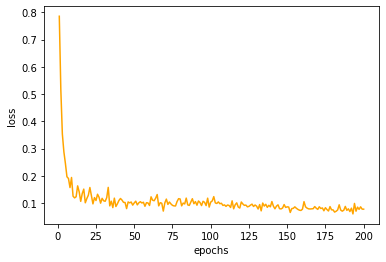

In [ ]:
_ = history_df['loss'].plot.line(xlabel='epochs', ylabel='loss', color='orange')

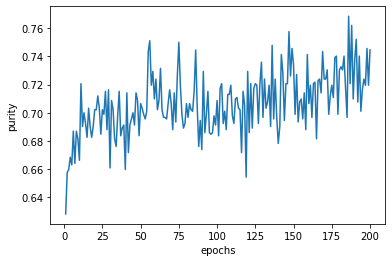

In [ ]:
_ = history_df['purity'].plot.line(xlabel='epochs', ylabel='purity')

# Linear Evaluation

### Misc Setup

In [26]:
def load_weights(model, wts_path, output_dim, arch):
    wts = torch.load(wts_path)
    # pdb.set_trace()
    if 'state_dict' in wts:
        ckpt = wts['state_dict']
    elif 'model' in wts:
        ckpt = wts['model']
    else:
        ckpt = wts

    ckpt = {k.replace('module.', ''): v for k, v in ckpt.items()}
    ckpt = {k: v for k, v in ckpt.items() if 'encoder_t' not in k}
    ckpt = {k.replace('encoder_q.', ''): v for k, v in ckpt.items()}
    state_dict = {}

    for m_key, m_val in model.state_dict().items():
        if m_key in ckpt:
            state_dict[m_key] = ckpt[m_key]
        else:
            state_dict[m_key] = m_val
            print('not copied => ' + m_key)

    model.load_state_dict(state_dict)

    predict_q_ckpt = {k: v for k, v in ckpt.items() if 'predict_q' in k}
    predict_q_ckpt = {k.replace('predict_q.', ''): v for k, v in predict_q_ckpt.items()}
    predict_q_model = get_mlp(output_dim, output_dim * 2, output_dim)

    predict_q_state_dict = {}

    for m_key, m_val in predict_q_model.state_dict().items():
        if m_key in predict_q_ckpt:
            predict_q_state_dict[m_key] = predict_q_ckpt[m_key]
        else:
            predict_q_state_dict[m_key] = m_val
            print('not copied => ' + m_key)

    predict_q_model.load_state_dict(predict_q_state_dict)

    if arch == 'healnet':
        model.fc_16 = nn.Sequential(model.fc_16, predict_q_model)
    else:
        model.fc = nn.Sequential(model.fc, predict_q_model)

In [27]:
def get_model(arch, output_dim, wts_path):
    model, _ = initialize_encoder(arch, output_dim)
    load_weights(model, wts_path, output_dim, arch)

    # if arch == 'alexnet':
    #     model = AlexNet()
    #     model.fc = nn.Sequential()
    #     load_weights(model, wts_path)
    # elif arch == 'pt_alexnet':
    #     model = models.alexnet()
    #     classif = list(model.classifier.children())[:5]
    #     model.classifier = nn.Sequential(*classif)
    #     load_weights(model, wts_path)
    # elif arch == 'mobilenet':
    #     model = MobileNetV2()
    #     model.fc = nn.Sequential()
    #     load_weights(model, wts_path)
    # elif 'sup_resnet' in arch:
    #     model = models.__dict__[arch.replace('sup_', '')](pretrained=True)
    #     model.fc = nn.Sequential()
    # elif 'resnet' in arch:
    #     model = models.__dict__[arch]()
    #     model.fc = nn.Sequential()
    #     load_weights(model, wts_path)
    # else:
    #     raise ValueError('arch not found: ' + arch)

    for p in model.parameters():
        p.requires_grad = False

    return model

In [28]:
class Normalize(nn.Module):
    def forward(self, x):
        return x / x.norm(2, dim=1, keepdim=True)


class FullBatchNorm(nn.Module):
    def __init__(self, var, mean):
        super(FullBatchNorm, self).__init__()
        self.register_buffer('inv_std', (1.0 / torch.sqrt(var + 1e-5)))
        self.register_buffer('mean', mean)

    def forward(self, x):
        return (x - self.mean) * self.inv_std

In [29]:
def get_channels(arch):
    if arch == 'alexnet':
        c = 4096
    elif arch == 'pt_alexnet':
        c = 4096
    elif 'resnet50' in arch:
        c = 2048
    elif arch == 'resnet18':
        c = 512
    elif arch == 'mobilenet':
        c = 1280
    else:
        raise ValueError('arch not found: ' + arch)
    return c

In [30]:
def normalize(x):
    return x / x.norm(2, dim=1, keepdim=True)

In [31]:
def get_feats(loader, model, print_freq, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    progress = ProgressMeter(
        len(loader),
        [batch_time],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()
    feats, labels, ptr = None, None, 0

    with torch.no_grad():
        end = time.time()
        for i, (indices, images, target) in enumerate(loader):
            images = images.cuda(non_blocking=True)
            cur_targets = target.cpu()
            cur_feats = normalize(model(images)).cpu()
            B, D = cur_feats.shape
            inds = torch.arange(B) + ptr

            if not ptr:
                feats = torch.zeros((len(loader.dataset), D)).float()
                labels = torch.zeros(len(loader.dataset)).long()

            feats.index_copy_(0, inds, cur_feats)
            labels.index_copy_(0, inds, cur_targets.argmax(axis=1))
            ptr += B

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

    return feats, labels

### Training Functions

In [32]:
def train(train_loader, backbone, linear, optimizer, epoch, print_freq, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    data_time = AverageMeter('Data', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top2 = AverageMeter('Acc@2', ':6.2f')
    progress = ProgressMeter(
        len(train_loader),
        [batch_time, data_time, losses, top1, top2],
        prefix="Epoch: [{}]".format(epoch))

    # switch to train mode
    backbone.eval()
    linear.train()

    end = time.time()
    for i, (indices, images, target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)

        images = images.cuda(non_blocking=True)
        target = target.cuda(non_blocking=True)

        # compute output
        with torch.no_grad():
            output = backbone(images)
        output = linear(output)
        loss = F.cross_entropy(output, target)

        # measure accuracy and record loss
        acc1, acc2 = accuracy(output, target.argmax(axis=1), topk=(1, 2))
        losses.update(loss.item(), images.size(0))
        top1.update(acc1[0], images.size(0))
        top2.update(acc2[0], images.size(0))

        # compute gradient and do SGD step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % print_freq == 0:
            print(progress.display(i))

    return losses.avg, top1.avg.item(), top2.avg.item()

In [33]:
def validate(val_loader, backbone, linear, print_freq, logger):
    batch_time = AverageMeter('Time', ':6.3f')
    losses = AverageMeter('Loss', ':.4e')
    top1 = AverageMeter('Acc@1', ':6.2f')
    top2 = AverageMeter('Acc@2', ':6.2f')
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top2],
        prefix='Test: ')

    backbone.eval()
    linear.eval()

    with torch.no_grad():
        end = time.time()
        for i, (indices, images, target) in enumerate(val_loader):
            images = images.cuda(non_blocking=True)
            target = target.cuda(non_blocking=True)

            # compute output
            output = backbone(images)
            output = linear(output)
            loss = F.cross_entropy(output, target)

            # measure accuracy and record loss
            
            acc1, acc2 = accuracy(output, target.argmax(axis=1), topk=(1, 2))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top2.update(acc2[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

        # TODO: this should also be done with the ProgressMeter
        print(' * Acc@1 {top1.avg:.3f} Acc@2 {top2.avg:.3f}'
              .format(top1=top1, top2=top2))

    return losses.avg, top1.avg.item(), top2.avg.item()

In [34]:
def main_worker(data, label_fn, weights, save, logger, batch_size=16, workers=2, 
                epochs=40, arch='resnet50', print_freq=10, mlp=True, lr=0.01, 
                momentum=0.9, weight_decay=1e-4, lr_schedule='15,30,40', 
                resume=None, evaluate=False, n_classes=4, output_dim=16):
    best_acc1 = 0
    best_loss = np.inf

    # Data loading code
    traindir = os.path.join(data, 'train')
    valdir = os.path.join(data, 'val')
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

    train_transform = transforms.Compose([
        #transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.RandomRotation((0, 360)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
    ])

    val_transform = transforms.Compose([
        #transforms.Resize(256),
        #transforms.CenterCrop(224),
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize,
    ])

    train_dataset = Image_Dataset(traindir, label_fn, train_transform)
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size, shuffle=True,
        num_workers=workers, pin_memory=True,
    )

    val_loader = torch.utils.data.DataLoader(
        Image_Dataset(valdir, label_fn, val_transform),
        batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True,
    )

    train_val_loader = torch.utils.data.DataLoader(
        Image_Dataset(traindir, label_fn, val_transform),
        batch_size=batch_size, shuffle=False,
        num_workers=workers, pin_memory=True,
    )

    backbone = get_model(arch, output_dim, weights)
    backbone = nn.DataParallel(backbone).cuda()
    backbone.eval()


    cached_feats = '%s/var_mean.pth.tar' % save
    if not os.path.exists(cached_feats):
        train_feats, _ = get_feats(train_val_loader, backbone, print_freq, logger)
        train_var, train_mean = torch.var_mean(train_feats, dim=0)
        torch.save((train_var, train_mean), cached_feats)
    else:
        train_var, train_mean = torch.load(cached_feats)
    if mlp:
        c = output_dim
        linear = nn.Sequential(
            Normalize(),
            FullBatchNorm(train_var, train_mean),
            nn.Linear(output_dim, c),
            nn.BatchNorm1d(c),
            nn.ReLU(inplace=True),
            nn.Linear(c, c),
            nn.BatchNorm1d(c),
            nn.ReLU(inplace=True),
            nn.Linear(c, n_classes),
        )
    else:
        linear = nn.Sequential(
            Normalize(),
            FullBatchNorm(train_var, train_mean),
            nn.Linear(output_dim, n_classes)
        )

    print(backbone)
    print(linear)

    linear = linear.cuda()

    optimizer = torch.optim.SGD(linear.parameters(),
                                lr,
                                momentum=momentum,
                                weight_decay=weight_decay)

    sched = [int(x) for x in lr_schedule.split(',')]
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(
        optimizer, milestones=sched
    )

    start_epoch = 0
    history_df = pd.DataFrame(index=range(start_epoch + 1, epochs + 1))

    # optionally resume from a checkpoint
    if resume:
        if os.path.isfile(resume):
            print("=> loading checkpoint '{}'".format(resume))
            checkpoint = torch.load(resume)
            start_epoch = checkpoint['epoch']
            linear.load_state_dict(checkpoint['state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer'])
            lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
            history_df = checkpoint['history_df']
            print("=> loaded checkpoint '{}' (epoch {})"
                  .format(resume, checkpoint['epoch']))
        else:
            print("=> no checkpoint found at '{}'".format(resume))

    cudnn.benchmark = True

    if evaluate:
        validate(val_loader, backbone, linear, print_freq, logger)
        return

    for epoch in range(start_epoch, epochs):
        # train for one epoch
        loss, acc1, acc2 = train(
            train_loader, backbone, linear, optimizer, epoch, print_freq, logger)

        # evaluate on validation set
        val_loss, val_acc1, val_acc2 = validate(
            val_loader, backbone, linear, print_freq, logger)
        
        history_df.loc[epoch + 1, 'train_loss'] = loss
        history_df.loc[epoch + 1, 'train_acc1'] = acc1
        history_df.loc[epoch + 1, 'train_acc2'] = acc2
        history_df.loc[epoch + 1, 'val_loss'] = val_loss
        history_df.loc[epoch + 1, 'val_acc1'] = val_acc1
        history_df.loc[epoch + 1, 'val_acc2'] = val_acc2

        # modify lr
        lr_scheduler.step()
        # logger.info('LR: {:f}'.format(lr_scheduler.get_last_lr()[-1]))

        # remember best acc@1 and save checkpoint
        #is_best = val_acc1 > best_acc1
        is_best = val_loss < best_loss
        if is_best:
            best_loss = val_loss


        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': linear.state_dict(),
            'optimizer': optimizer.state_dict(),
            'lr_scheduler': lr_scheduler.state_dict(),
            'backbone': backbone,
            'linear': linear,
            'history_df': history_df
        }, is_best, save)

    return backbone, linear

In [35]:
!touch logger_init
def main_linear_eval(data, label_fn, weights, save, batch_size=16, workers=2, 
                     epochs=40, arch='resnet50', print_freq=10, mlp=True, lr=0.01, 
                     momentum=0.9, weight_decay=1e-4, lr_schedule='15,30,40', 
                     resume=None, evaluate=False, seed=None, n_classes=4, output_dim=16):
    args = locals()
    del args['label_fn']

    if not resume:
        os.makedirs(save)
    logger = get_logger(logpath=os.path.join(save, 'logs'), filepath='logger_init')
    print(args)

    if seed is not None:
        random.seed(seed)
        torch.manual_seed(seed)
        cudnn.deterministic = True
        warnings.warn('You have chosen to seed training. '
                      'This will turn on the CUDNN deterministic setting, '
                      'which can slow down your training considerably! '
                      'You may see unexpected behavior when restarting '
                      'from checkpoints.')

    return main_worker(data=data, label_fn=label_fn, weights=weights, save=save, 
                       logger=logger, batch_size=batch_size, workers=workers, 
                       epochs=epochs, arch=arch, print_freq=print_freq, mlp=mlp, 
                       lr=lr, momentum=momentum, weight_decay=weight_decay, 
                       lr_schedule=lr_schedule, resume=resume, evaluate=evaluate, 
                       n_classes=n_classes, output_dim=output_dim)

### Getting Labels

In [36]:
labels_df = pd.read_csv(root_path + 'Updated_Cropped_Images_Wound_Stage_Probabilities.csv', index_col='Image')
labels_df.head()

,hemostasis,inflammatory,proliferative,maturation
Image,,,,
Day 8_A8-4-L.png,0.181818,0.090909,0.545455,0.181818
Day 4_A8-3-R.png,0.090909,0.909091,0.000000,0.000000
Day 14_Y8-4-L.png,0.000000,0.000000,0.090909,0.909091
Day 7_Y8-4-L.png,0.000000,0.000000,0.454545,0.545455
Day 2_A8-1-L.png,0.181818,0.727273,0.090909,0.000000


In [37]:
labels_df.loc['Day 8_A8-4-L.png'].to_numpy()

array([0.18181818, 0.09090909, 0.54545455, 0.18181818])

### Epoch number of CMSF to evaluate

In [38]:
epoch = '200'
eval_suffix = '_1_'

# Linear Evaluation Training

### Training

In [ ]:
_, _ = main_linear_eval(
    data=root_path + 'Split_images', 
    label_fn=lambda x: labels_df.loc[x].to_numpy(), 
    weights=root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + epoch + '.pth',
    save=root_path + 'outputs/' + train_folder_name + 'eval' + eval_suffix + epoch + '/', 
    batch_size=8, 
    lr=0.01,
    epochs=40, 
    mlp=True,
    workers=2, 
    arch='resnet_healnet', 
    print_freq=10,  
    output_dim=16)

logger_init
logger_init
logger_init



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


{'data': 'gdrive/MyDrive/Explainable_Wound_Classification/Split_images', 'weights': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised/13_resnet_healnet_frozen/ckpt_epoch_200.pth', 'save': 'gdrive/MyDrive/Explainable_Wound_Classification/outputs/unsupervised/13_resnet_healnet_frozen/eval_1_200/', 'batch_size': 8, 'workers': 2, 'epochs': 40, 'arch': 'resnet_healnet', 'print_freq': 10, 'mlp': True, 'lr': 0.01, 'momentum': 0.9, 'weight_decay': 0.0001, 'lr_schedule': '15,30,40', 'resume': None, 'evaluate': False, 'seed': None, 'n_classes': 4, 'output_dim': 16}
Test: [ 0/24]	Time  0.485 ( 0.485)
Test: [10/24]	Time  0.067 ( 0.080)
Test: [20/24]	Time  0.067 ( 0.066)
DataParallel(
  (module): ResnetEncoder(
    (embed_model): ResNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(

### Graphs

In [ ]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + epoch + '/checkpoint.pth.tar')
history_df = cpkt['history_df']
cpkt['epoch']

40

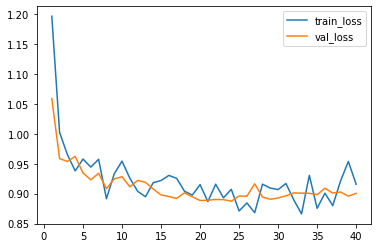

In [ ]:
_ = history_df[['train_loss', 'val_loss']].plot.line()

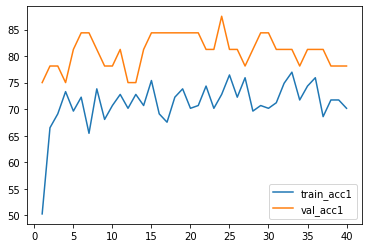

In [ ]:
_ = history_df[['train_acc1', 'val_acc1']].plot.line()

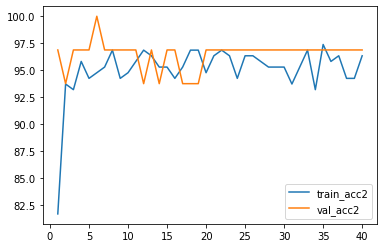

In [ ]:
_ = history_df[['train_acc2', 'val_acc2']].plot.line()

# Test Set

In [39]:
test_loader, samples = get_val_loader(
    root_path + 'Split_images',
    lambda x: labels_df.loc[x].to_numpy(),
    2,
    test=True)

In [40]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + epoch + '/model_best.pth.tar')
backbone = cpkt['backbone']
linear = cpkt['linear']
best_epoch = cpkt['epoch']
print('Best Epoch:', best_epoch)
print('Val_acc:', cpkt['history_df']['val_acc1'][best_epoch])

Best Epoch: 24
Val_acc: 87.5


In [41]:
cpkt['history_df']['val_loss']

1     1.058856
2     0.958517
3     0.953689
4     0.962129
5     0.934534
6     0.922971
7     0.933975
8     0.908295
9     0.924535
10    0.928271
11    0.911323
12    0.921961
13    0.918810
14    0.907596
15    0.897775
16    0.895195
17    0.891968
18    0.901309
19    0.894729
20    0.888462
21    0.889000
22    0.890278
23    0.889966
24    0.887295
25         NaN
26         NaN
27         NaN
28         NaN
29         NaN
30         NaN
31         NaN
32         NaN
33         NaN
34         NaN
35         NaN
36         NaN
37         NaN
38         NaN
39         NaN
40         NaN
Name: val_loss, dtype: float64

In [42]:
backbone.eval()
linear.eval()

Sequential(
  (0): Normalize()
  (1): FullBatchNorm()
  (2): Linear(in_features=16, out_features=16, bias=True)
  (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): ReLU(inplace=True)
  (5): Linear(in_features=16, out_features=16, bias=True)
  (6): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): ReLU(inplace=True)
  (8): Linear(in_features=16, out_features=4, bias=True)
)

In [43]:
preds, names, labels = None, None, None

with torch.no_grad():
    for indices, images, labels in test_loader:
        preds = linear(backbone(images)).softmax(dim=1).cpu().numpy()
        names = np.array([x.split('/')[-1] for x in samples])
        labels = labels.numpy()

df = pd.DataFrame(index=names)
preds = [list(x) for x in preds]
labels = [list(x) for x in labels]
df['target'] = labels
df['pred'] = preds
df.head()

,target,pred
Day 14_Y8-4-L.png,"[0.0, 0.0, 0.0909090909090909, 0.909090909090909]","[0.007489723, 0.022977281, 0.16307792, 0.806455]"
Day 7_Y8-4-L.png,"[0.0, 0.0, 0.454545454545455, 0.545454545454545]","[0.059980813, 0.16082749, 0.5049446, 0.27424705]"
Day 9_A8-1-R.png,"[0.0909090909090909, 0.454545454545455, 0.4545...","[0.26238966, 0.39461353, 0.31598973, 0.027007082]"
Day 4_A8-1-R.png,"[0.363636363636364, 0.636363636363636, 0.0, 0.0]","[0.50253356, 0.4312618, 0.0635738, 0.0026308622]"
Day 12_A8-1-R.png,"[0.0, 0.2, 0.5, 0.3]","[0.035981048, 0.178081, 0.53540224, 0.25053573]"


In [44]:
props = df.index.map(lambda x: re.match('^Day (\d+)_(Y|A)8-(\d)-(L|R)', x).groups())
df['Day'] = props.map(lambda x: int(x[0]))
df['Age'] = props.map(lambda x: x[1])
df['Mouse'] = props.map(lambda x: int(x[2]))
df['Side'] = props.map(lambda x: x[3])
df['True, Pred'] = (df.index.map(lambda x: [np.argmax(df.loc[x]['target']), np.argmax(df.loc[x]['pred'])]))
df.head()

,target,pred,Day,Age,Mouse,Side,"True, Pred"
Day 14_Y8-4-L.png,"[0.0, 0.0, 0.0909090909090909, 0.909090909090909]","[0.007489723, 0.022977281, 0.16307792, 0.806455]",14,Y,4,L,"[3, 3]"
Day 7_Y8-4-L.png,"[0.0, 0.0, 0.454545454545455, 0.545454545454545]","[0.059980813, 0.16082749, 0.5049446, 0.27424705]",7,Y,4,L,"[3, 2]"
Day 9_A8-1-R.png,"[0.0909090909090909, 0.454545454545455, 0.4545...","[0.26238966, 0.39461353, 0.31598973, 0.027007082]",9,A,1,R,"[1, 1]"
Day 4_A8-1-R.png,"[0.363636363636364, 0.636363636363636, 0.0, 0.0]","[0.50253356, 0.4312618, 0.0635738, 0.0026308622]",4,A,1,R,"[1, 0]"
Day 12_A8-1-R.png,"[0.0, 0.2, 0.5, 0.3]","[0.035981048, 0.178081, 0.53540224, 0.25053573]",12,A,1,R,"[2, 2]"


In [45]:
young_df = df[df.Age == 'Y']
young_df.sort_values('Day')[['target', 'pred', 'True, Pred']]

,target,pred,"True, Pred"
Day 0_Y8-4-L.png,"[1.0, 0.0, 0.0, 0.0]","[0.8866129, 0.09936316, 0.012154892, 0.0018691...","[0, 0]"
Day 1_Y8-4-L.png,"[0.57, 0.43, 0.0, 0.0]","[0.039197296, 0.20416655, 0.5354733, 0.22116292]","[0, 2]"
Day 2_Y8-4-L.png,"[0.8, 0.2, 0.0, 0.0]","[0.5825909, 0.37159225, 0.042144082, 0.0036727...","[0, 0]"
Day 3_Y8-4-L.png,"[0.2, 0.8, 0.0, 0.0]","[0.13193569, 0.48312715, 0.37090003, 0.014037102]","[1, 1]"
Day 4_Y8-4-L.png,"[0.4, 0.5, 0.1, 0.0]","[0.8101399, 0.17248759, 0.015093031, 0.0022794...","[1, 0]"
Day 5_Y8-4-L.png,"[0.3, 0.5, 0.2, 0.0]","[0.3635218, 0.42767918, 0.19523662, 0.0135623785]","[1, 1]"
Day 6_Y8-4-L.png,"[0.1, 0.3, 0.6, 0.0]","[0.07066419, 0.30745423, 0.49308085, 0.1288008]","[2, 2]"
Day 7_Y8-4-L.png,"[0.0, 0.0, 0.454545454545455, 0.545454545454545]","[0.059980813, 0.16082749, 0.5049446, 0.27424705]","[3, 2]"
Day 8_Y8-4-L.png,"[0.0, 0.0, 0.6, 0.4]","[0.043539107, 0.16859415, 0.50007594, 0.2877908]","[2, 2]"
Day 9_Y8-4-L.png,"[0.0, 0.0, 0.6, 0.4]","[0.0102783665, 0.078509316, 0.42804658, 0.4831...","[2, 3]"


In [46]:
aged_df = df[df.Age == 'A']
aged_df.sort_values('Day')[['target', 'pred', 'True, Pred']]

,target,pred,"True, Pred"
Day 0_A8-1-R.png,"[0.9, 0.1, 0.0, 0.0]","[0.73697037, 0.23767257, 0.023418948, 0.001938...","[0, 0]"
Day 1_A8-1-R.png,"[0.1, 0.8, 0.1, 0.0]","[0.15218952, 0.29620752, 0.44917938, 0.10242351]","[1, 2]"
Day 2_A8-1-R.png,"[0.4, 0.5, 0.1, 0.0]","[0.24520639, 0.5814292, 0.16983499, 0.0035294346]","[1, 1]"
Day 3_A8-1-R.png,"[0.4, 0.5, 0.1, 0.0]","[0.549038, 0.39992672, 0.048468236, 0.0025670058]","[1, 0]"
Day 4_A8-1-R.png,"[0.363636363636364, 0.636363636363636, 0.0, 0.0]","[0.50253356, 0.4312618, 0.0635738, 0.0026308622]","[1, 0]"
Day 5_A8-1-R.png,"[0.2, 0.5, 0.3, 0.0]","[0.15350127, 0.58634675, 0.25484157, 0.005310458]","[1, 1]"
Day 6_A8-1-R.png,"[0.2, 0.7, 0.1, 0.0]","[0.141381, 0.5254466, 0.32393864, 0.009233826]","[1, 1]"
Day 7_A8-1-R.png,"[0.1, 0.7, 0.1, 0.1]","[0.14618199, 0.36076376, 0.4532461, 0.039808143]","[1, 2]"
Day 8_A8-1-R.png,"[0.2, 0.6, 0.2, 0.0]","[0.28664702, 0.3460041, 0.32611704, 0.041231807]","[1, 1]"
Day 9_A8-1-R.png,"[0.0909090909090909, 0.454545454545455, 0.4545...","[0.26238966, 0.39461353, 0.31598973, 0.027007082]","[1, 1]"


In [47]:
test_acc = df['True, Pred'].map(lambda x: x[0] == x[1]).to_numpy().mean()
print('Test_acc:', test_acc * 100)

Test_acc: 68.75


# Some Cluster Analysis

In [ ]:
data_path = root_path + 'Split_images'
weights_path = root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + epoch + '.pth'

encoder = get_model('resnet', 16, weights_path)
train_val_loader, train_samples = get_val_loader(data_path, lambda x: labels_df.loc[x].to_numpy(), 0, train=True)

In [ ]:
encoder.eval()

with torch.no_grad():
    for indices, images, labels in train_val_loader:
        embeddings = encoder(images)

        _, fcm = fuzzy_c_means(embeddings, 4)
        preds = fcm.soft_predict(embeddings.numpy())
        labels = labels.numpy()
        x = 4


In [ ]:
single_preds = preds.argmax(axis=1)
single_labels = labels.argmax(axis=1)

In [ ]:
pred_indices_0 = [i for (i, x) in enumerate(single_preds) if x == 0]
pred_indices_1 = [i for (i, x) in enumerate(single_preds) if x == 1]
pred_indices_2 = [i for (i, x) in enumerate(single_preds) if x == 2]
pred_indices_3 = [i for (i, x) in enumerate(single_preds) if x == 3]

In [ ]:
print(stats.mode(single_labels[pred_indices_0])[0][0])
print(stats.mode(single_labels[pred_indices_1])[0][0])
print(stats.mode(single_labels[pred_indices_2])[0][0])
print(stats.mode(single_labels[pred_indices_3])[0][0])

0
1
2
3


In [ ]:
single_labels[pred_indices_1]

array([3, 2, 2, 1, 2, 2, 2, 2, 3, 2, 2, 3, 1, 2, 2, 2, 2, 2, 2, 2, 2, 3,
       2, 2, 3, 2, 2, 2, 2, 2])

In [ ]:
single_labels[pred_indices_2]

array([2, 1, 2, 2, 3, 2, 0, 2, 1, 1, 2, 2, 0, 2, 2, 2, 1, 2, 1, 1, 2, 0,
       2, 1, 2, 2, 2, 1, 1, 0, 2, 2, 0, 3, 2, 2, 2])

In [ ]:
#have to change this m dict based on which clusters are which class
m = {0:0, 1:1, 2:2, 3:3}
preds = np.array([[p[m[0]], p[m[1]], p[m[2]], p[m[3]]] for p in preds])

In [ ]:
single_preds = preds.argmax(axis=1)

In [ ]:
acc = (single_preds == single_labels).mean()
acc

0.6178010471204188

# KNN Evaluation

### Misc Functions

In [258]:
def l2_normalize(x):
    return x / x.norm(2, dim=1, keepdim=True)

In [259]:
def log(string, file):
    print(string)
    file.write(string + '\n')

In [260]:
def faiss_knn(feats_train, targets_train, feats_val, targets_val, k):
    feats_train = feats_train.numpy()
    targets_train = targets_train.numpy()
    feats_val = feats_val.numpy()
    targets_val = targets_val.numpy()

    d = feats_train.shape[-1]

    index = faiss.IndexFlatL2(d)  # build the index
    co = faiss.GpuMultipleClonerOptions()
    co.useFloat16 = True
    co.shard = True
    gpu_index = faiss.index_cpu_to_all_gpus(index, co)
    gpu_index.add(feats_train)

    D, I = gpu_index.search(feats_val, k)

    pred = np.zeros(I.shape[0], dtype=int)
    conf_mat = np.zeros((1000, 1000), dtype=int)
    for i in range(I.shape[0]):
        votes = list(Counter(targets_train[I[i]]).items())
        shuffle(votes)
        pred[i] = max(votes, key=lambda x: x[1])[0]
        conf_mat[targets_val[i], pred[i]] += 1

    acc = 100.0 * (pred == targets_val).mean()
    assert acc == (100.0 * (np.trace(conf_mat) / np.sum(conf_mat)))

    # per_cat_acc = 100.0 * (np.diag(conf_mat) / np.sum(conf_mat, axis=1))
    # sparse_cats = [58, 155, 356, 747, 865, 234, 268, 384, 385, 491, 498, 538, 646, 650, 726, 860, 887, 15, 170, 231]
    # s = ' '.join('{}'.format(c) for c in sparse_cats)
    # print('==> cats: {}'.format(s))
    # s = ' '.join('{:.1f}'.format(a) for a in per_cat_acc[sparse_cats])
    # print('==> acc/cat: {}'.format(s))
    # print('==> mean acc: {}'.format(per_cat_acc[sparse_cats].mean()))

    return acc

In [261]:
def get_feats(loader, model, print_freq):
    batch_time = AverageMeter('Time', ':6.3f')
    progress = ProgressMeter(
        len(loader),
        [batch_time],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()
    feats, labels, indices, ptr = None, None, None, 0

    with torch.no_grad():
        end = time.time()
        for i, (index, images, target) in enumerate(loader):
            images = images.cuda(non_blocking=True)
            cur_targets = target.cpu()
            cur_feats = model(images).cpu()
            cur_indices = index.cpu()

            B, D = cur_feats.shape
            inds = torch.arange(B) + ptr

            if not ptr:
                feats = torch.zeros((len(loader.dataset), D)).float()
                labels = torch.zeros(len(loader.dataset)).long()
                indices = torch.zeros(len(loader.dataset)).long()

            feats.index_copy_(0, inds, cur_feats)
            labels.index_copy_(0, inds, cur_targets)
            indices.index_copy_(0, inds, cur_indices)
            ptr += B

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % print_freq == 0:
                print(progress.display(i))

    return feats, labels, indices

In [262]:
def subset_classes(dataset, num_classes=10):
    np.random.seed(1234)
    all_classes = sorted(dataset.class_to_idx.items(), key=lambda x: x[1])
    subset_classes = [all_classes[i] for i in np.random.permutation(len(all_classes))[:num_classes]]
    subset_classes = sorted(subset_classes, key=lambda x: x[1])
    dataset.classes_to_idx = {c: i for i, (c, _) in enumerate(subset_classes)}
    dataset.classes = [c for c, _ in subset_classes]
    orig_to_new_inds = {orig_ind: new_ind for new_ind, (_, orig_ind) in enumerate(subset_classes)}
    dataset.samples = [(p, orig_to_new_inds[i]) for p, i in dataset.samples if i in orig_to_new_inds]

### Main Function

In [263]:
def main_worker(arch, output_dim, data_path, wts_path, output_path, batch_size, 
                label_fn, num_workers=2, print_freq=10):

    start = time.time()
    # Get train/val loader 
    # ---------------------------------------------------------------
    train_loader, _ = get_val_loader(data_path, label_fn, num_workers, batch_size, train=True)
    val_loader, _   = get_val_loader(data_path, label_fn, num_workers, batch_size)
    test_loader, _  = get_val_loader(data_path, label_fn, num_workers, batch_size, test=True)

    # Create and load the model
    # If you want to evaluate your model, modify this part and load your model
    # ------------------------------------------------------------------------
    # MODIFY 'get_model' TO EVALUATE YOUR MODEL
    model = get_model(arch, output_dim, wts_path).cuda()

    # ------------------------------------------------------------------------
    # Forward training samples throw the model and cache feats
    # ------------------------------------------------------------------------
    cudnn.benchmark = True

    train_feats, train_labels, train_inds = get_feats(train_loader, model, print_freq)

    val_feats, val_labels, val_inds = get_feats(val_loader, model, print_freq)

    test_feats, test_labels, test_inds = get_feats(test_loader, model, print_freq)

    # ------------------------------------------------------------------------
    # Calculate NN accuracy on validation set
    # ------------------------------------------------------------------------

    # train_feats = l2_normalize(train_feats)
    # val_feats = l2_normalize(val_feats)

    # mean = torch.mean(train_feats, dim=0)
    # std = torch.std(train_feats, dim=0)

    # stdmean = std.mean()
    # train_feats = train_feats / stdmean
    # val_feats = val_feats / stdmean

    # train_feats = train_feats / std
    # val_feats = val_feats / std

    # train_feats = (train_feats - mean) / std
    # val_feats = (val_feats - mean) / std

    # train_feats = train_feats - mean
    # val_feats = val_feats - mean

    # train_feats = train_feats / TEMP
    # val_feats = val_feats / TEMP

    train_feats = l2_normalize(train_feats)
    val_feats = l2_normalize(val_feats)
    test_feats = l2_normalize(test_feats)

    output = open(output_path, 'w')

    for k in range(1,21):
        log(f'k: {k}', output)
        val_acc  = faiss_knn(train_feats, train_labels, val_feats, val_labels, k)
        test_acc = faiss_knn(train_feats, train_labels, test_feats, test_labels, k)
        nn_time = time.time() - start
        #log('=> time : {:.2f}s'.format(nn_time), output)
        log(' * Val_Acc {:.2f}'.format(val_acc), output)
        log(' * Test_Acc {:.2f}'.format(test_acc), output)

    output.close()

### Evaluation

In [264]:
main_worker(arch='resnet_healnet', 
            output_dim=16, 
            data_path=root_path + 'Split_images', 
            wts_path=root_path + 'outputs/' + train_folder_name + 'ckpt_epoch_' + epoch + '.pth', 
            output_path=root_path + 'outputs/' + train_folder_name + 'eval' + eval_suffix + 'knn_' + epoch, 
            batch_size=8, 
            label_fn=lambda x: labels_map[x], 
            num_workers=2, 
            print_freq=10)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Test: [ 0/24]	Time  0.253 ( 0.253)
Test: [10/24]	Time  0.055 ( 0.052)
Test: [20/24]	Time  0.033 ( 0.042)
Test: [0/4]	Time  0.181 ( 0.181)
Test: [0/4]	Time  0.179 ( 0.179)
k: 1
 * Val_Acc 56.25
 * Test_Acc 62.50
k: 2
 * Val_Acc 59.38
 * Test_Acc 65.62
k: 3
 * Val_Acc 68.75
 * Test_Acc 65.62
k: 4
 * Val_Acc 71.88
 * Test_Acc 71.88
k: 5
 * Val_Acc 78.12
 * Test_Acc 68.75
k: 6
 * Val_Acc 68.75
 * Test_Acc 71.88
k: 7
 * Val_Acc 75.00
 * Test_Acc 71.88
k: 8
 * Val_Acc 75.00
 * Test_Acc 71.88
k: 9
 * Val_Acc 78.12
 * Test_Acc 75.00
k: 10
 * Val_Acc 71.88
 * Test_Acc 75.00
k: 11
 * Val_Acc 68.75
 * Test_Acc 78.12
k: 12
 * Val_Acc 68.75
 * Test_Acc 75.00
k: 13
 * Val_Acc 71.88
 * Test_Acc 75.00
k: 14
 * Val_Acc 68.75
 * Test_Acc 75.00
k: 15
 * Val_Acc 68.75
 * Test_Acc 78.12
k: 16
 * Val_Acc 68.75
 * Test_Acc 78.12
k: 17
 * Val_Acc 68.75
 * Test_Acc 78.12
k: 18
 * Val_Acc 68.75
 * Test_Acc 78.12
k: 19
 * Val_Acc 68.75
 * Test_Acc 78.12
k: 20
 * Val_Acc 71.88
 * Test_Acc 78.12


# LIME

### Setup

In [ ]:
# Based off https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20images%20-%20Pytorch.ipynb

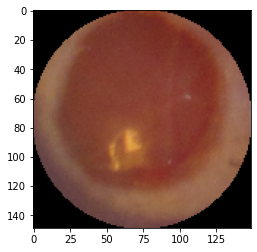

In [ ]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 
        
img = get_image(root_path + 'Circle_Cropped_images/Day 0_A8-1-R.png')
plt.imshow(img)

In [ ]:
# resize and take the center part of image to what our model expects
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

In [ ]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + epoch + '/model_best.pth.tar')
backbone = cpkt['backbone']
linear = cpkt['linear']

In [ ]:
img_t = get_input_tensors(img)
backbone.eval()
linear.eval()
probs = None
with torch.no_grad():
    probs = linear(backbone(img_t)).softmax(dim=1).cpu().numpy()
probs

array([[0.4987914 , 0.41793382, 0.07116882, 0.0121059 ]], dtype=float32)

In [ ]:
def get_pil_transform(): 
    transf = transforms.Compose([
        transforms.Resize(224),
    ])    

    return transf

def get_preprocess_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])     
    transf = transforms.Compose([
        transforms.ToTensor(),
        normalize
    ])    

    return transf    

pill_transf = get_pil_transform()
preprocess_transform = get_preprocess_transform()

In [ ]:
def batch_predict(images):
    backbone.eval()
    linear.eval()
    batch = torch.stack(tuple(preprocess_transform(i) for i in images), dim=0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    backbone.to(device)
    linear.to(device)
    batch = batch.to(device)
    
    probs = None
    with torch.no_grad():
        probs = linear(backbone(batch)).softmax(dim=1).detach().cpu().numpy()

    return probs

In [ ]:
test_pred = batch_predict([pill_transf(img)])
test_pred.squeeze().argmax()

0

In [ ]:
# explainer = lime_image.LimeImageExplainer()
# explanation = explainer.explain_instance(np.array(pill_transf(img)), 
#                                          batch_predict, # classification function
#                                          top_labels=1, 
#                                          hide_color=0, 
#                                          num_samples=1000) # number of images that will be sent to classification function

In [ ]:
# temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
# img_boundry1 = mark_boundaries(temp/255.0, mask)
# plt.imshow(img_boundry1)

In [ ]:
# temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
# img_boundry2 = mark_boundaries(temp/255.0, mask)
# plt.imshow(img_boundry2)

### Main Function

In [ ]:
def explain_images(image_names):
    for image_name in image_names:
        print(f'\n{image_name}')

        img = get_image(root_path + 'Circle_Cropped_images/' + image_name)
        plt.figure()
        plt.imshow(img)

        explainer = lime_image.LimeImageExplainer()
        explanation = explainer.explain_instance(np.array(pill_transf(img)), 
                                                batch_predict, # classification function
                                                top_labels=1, 
                                                hide_color=0, 
                                                num_samples=1000) # number of images that will be sent to classification function
        
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=False)
        img_boundry2 = mark_boundaries(temp/255.0, mask)
        plt.figure()
        plt.imshow(img_boundry2)

        true_dist = labels_df.loc[image_name].to_numpy()
        true_label = true_dist.argmax()

        pred_dist = batch_predict([pill_transf(img)]).squeeze()
        pred_label = pred_dist.argmax()

        print(f'True Label: {true_label}, {true_dist}')
        print(f'Pred Label: {pred_label}, {pred_dist}')

### Explanations


Day 0_Y8-4-L.png


  0%|          | 0/1000 [00:00<?, ?it/s]

True Label: 0, [1. 0. 0. 0.]
Pred Label: 0, [0.7006564  0.2628619  0.03197732 0.00450442]

Day 11_Y8-4-L.png


  0%|          | 0/1000 [00:00<?, ?it/s]

True Label: 3, [0. 0. 0. 1.]
Pred Label: 3, [6.9317041e-04 5.2543716e-03 9.0423517e-02 9.0362895e-01]

Day 4_A8-1-R.png


  0%|          | 0/1000 [00:00<?, ?it/s]

True Label: 1, [0.36363636 0.63636364 0.         0.        ]
Pred Label: 0, [0.5731049  0.36423457 0.05390238 0.00875813]

Day 12_A8-1-R.png


  0%|          | 0/1000 [00:00<?, ?it/s]

True Label: 2, [0.  0.2 0.5 0.3]
Pred Label: 3, [0.11045611 0.1414983  0.23718677 0.5108588 ]


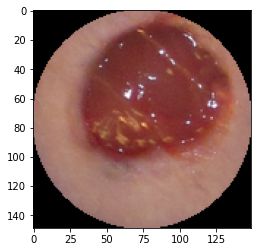

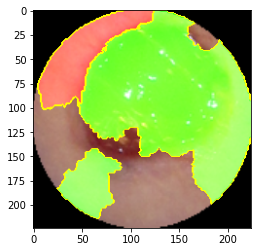

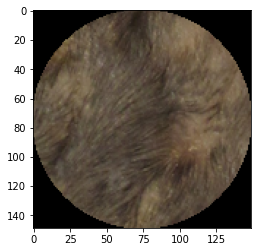

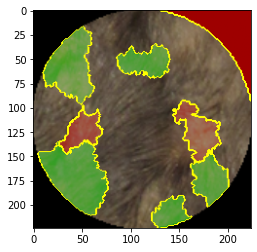

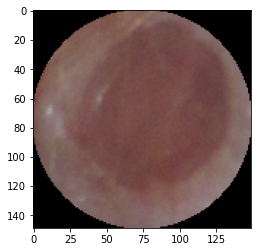

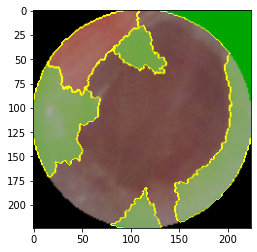

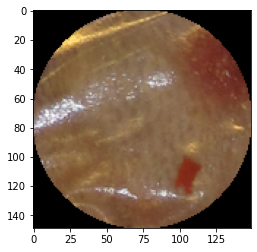

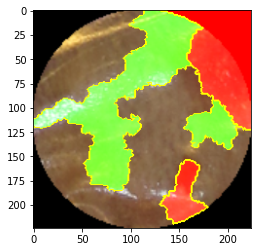

In [ ]:
explain_images(['Day 0_Y8-4-L.png', 'Day 11_Y8-4-L.png', 'Day 4_A8-1-R.png', 'Day 12_A8-1-R.png'])

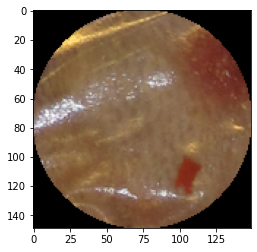

In [ ]:
img = get_image(root_path + 'Circle_Cropped_images/' + 'Day 12_A8-1-R.png')
plt.figure()
plt.imshow(img)

# Score CAM

### Score CAM

In [ ]:
# Based off of https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/scorecam.py

In [ ]:
class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, backbone, linear, target_layer):
        self.backbone = backbone
        self.linear = linear
        self.target_layer = target_layer

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.backbone._modules['module']._modules.items():
            if module_pos == 'fc':
                x = torch.flatten(x, 1)
            
            x = module(x)  # Forward

            if module_pos == self.target_layer:
                conv_output = x  # Save the convolution output on that layer
                
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = self.linear(x)
        return conv_output, x

In [ ]:
class ScoreCam():
    """
        Produces class activation map
    """
    def __init__(self, backbone, linear, target_layer):
        self.backbone = backbone
        self.linear = linear
        self.backbone.eval()
        self.linear.eval()
        # Define extractor
        self.extractor = CamExtractor(self.backbone, self.linear, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 4)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        probs = model_output.softmax(dim=1).detach().numpy()
        if target_class is None:
            target_class = np.argmax(probs)
        # Get convolution outputs
        target = conv_output[0]
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i in range(len(target)):
            # Unsqueeze to 4D
            saliency_map = torch.unsqueeze(torch.unsqueeze(target[i, :, :],0),0)
            # Upsampling to input size
            saliency_map = F.interpolate(saliency_map, size=(224, 224), mode='bilinear', align_corners=False)
            if saliency_map.max() == saliency_map.min():
                continue
            # Scale between 0-1
            norm_saliency_map = (saliency_map - saliency_map.min()) / (saliency_map.max() - saliency_map.min())
            # Get the target score
            w = F.softmax(self.extractor.forward_pass(input_image*norm_saliency_map)[1],dim=1)[0][target_class]
            cam += w.data.numpy() * target[i, :, :].data.numpy()
        cam = np.maximum(cam, 0)
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        return cam, probs, target_class

### Image Saving Functions

In [ ]:
# based off of https://github.com/utkuozbulak/pytorch-cnn-visualizations/blob/master/src/misc_functions.py

In [ ]:
def save_class_activation_images(org_img, activation_map, file_name):
    """
        Saves cam activation map and activation map on the original image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        file_name (str): File name of the exported image
    """
    if not os.path.exists('../results'):
        os.makedirs('../results')
    # Grayscale activation map
    heatmap, heatmap_on_image = apply_colormap_on_image(org_img, activation_map, 'hsv')
    # Save colored heatmap
    path_to_file = file_name+'_Cam_Heatmap.png'
    save_image(heatmap, path_to_file)
    # Save heatmap on iamge
    path_to_file = file_name+'_Cam_On_Image.png'
    save_image(heatmap_on_image, path_to_file)
    # SAve grayscale heatmap
    path_to_file = file_name+'_Cam_Grayscale.png'
    save_image(activation_map, path_to_file)


def apply_colormap_on_image(org_im, activation, colormap_name):
    """
        Apply heatmap on image
    Args:
        org_img (PIL img): Original image
        activation_map (numpy arr): Activation map (grayscale) 0-255
        colormap_name (str): Name of the colormap
    """
    # Get colormap
    color_map = mpl_color_map.get_cmap(colormap_name)
    no_trans_heatmap = color_map(activation)
    # Change alpha channel in colormap to make sure original image is displayed
    heatmap = copy.copy(no_trans_heatmap)
    heatmap[:, :, 3] = 0.4
    heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
    no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

    # Apply heatmap on image
    heatmap_on_image = Image.new("RGBA", org_im.size)
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, org_im.convert('RGBA'))
    heatmap_on_image = Image.alpha_composite(heatmap_on_image, heatmap)
    return no_trans_heatmap, heatmap_on_image

def format_np_output(np_arr):
    """
        This is a (kind of) bandaid fix to streamline saving procedure.
        It converts all the outputs to the same format which is 3xWxH
        with using sucecssive if clauses.
    Args:
        im_as_arr (Numpy array): Matrix of shape 1xWxH or WxH or 3xWxH
    """
    # Phase/Case 1: The np arr only has 2 dimensions
    # Result: Add a dimension at the beginning
    if len(np_arr.shape) == 2:
        np_arr = np.expand_dims(np_arr, axis=0)
    # Phase/Case 2: Np arr has only 1 channel (assuming first dim is channel)
    # Result: Repeat first channel and convert 1xWxH to 3xWxH
    if np_arr.shape[0] == 1:
        np_arr = np.repeat(np_arr, 3, axis=0)
    # Phase/Case 3: Np arr is of shape 3xWxH
    # Result: Convert it to WxHx3 in order to make it saveable by PIL
    if np_arr.shape[0] == 3:
        np_arr = np_arr.transpose(1, 2, 0)
    # Phase/Case 4: NP arr is normalized between 0-1
    # Result: Multiply with 255 and change type to make it saveable by PIL
    if np.max(np_arr) <= 1:
        np_arr = (np_arr*255).astype(np.uint8)
    return np_arr

def save_image(im, path):
    """
        Saves a numpy matrix or PIL image as an image
    Args:
        im_as_arr (Numpy array): Matrix of shape DxWxH
        path (str): Path to the image
    """
    if isinstance(im, (np.ndarray, np.generic)):
        im = format_np_output(im)
        im = Image.fromarray(im)
    im.save(path)

### Misc Funcs

In [ ]:
def get_image(path):
    with open(os.path.abspath(path), 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB') 

In [ ]:
def get_input_transform():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225])       
    transf = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        normalize
    ])    

    return transf

def get_input_tensors(img):
    transf = get_input_transform()
    # unsqeeze converts single image to batch of 1
    return transf(img).unsqueeze(0)

### Generate Heatmaps

In [ ]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + epoch + '/model_best.pth.tar')
backbone = cpkt['backbone'].to('cpu')
linear = cpkt['linear'].to('cpu')

In [ ]:
image_name = 'Day 0_A8-1-R.png'

In [ ]:
img = get_image(root_path + 'Circle_Cropped_images/' + image_name)
img_t = get_input_tensors(img)

score_cam = ScoreCam(backbone, linear, target_layer='layer4')
cam, probs, target_class = score_cam.generate_cam(img_t)

save_path = root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + epoch + '/score_cam/'
os.makedirs(save_path, exist_ok=True)
save_class_activation_images(TF.resize(img, 224), cam, save_path + image_name)

# RISE

In [ ]:
cpkt = torch.load(root_path + 'outputs/' + train_folder_name + 'eval'+ eval_suffix + epoch + '/model_best.pth.tar')
backbone = cpkt['backbone']
linear = cpkt['linear']

for p in backbone.parameters():
    p.requires_grad = False
for p in linear.parameters():
    p.requires_grad = False

model = lambda x: linear(backbone(x)).softmax(dim=1)

In [ ]:
explainer = RISE(model, (224, 224), 250)

In [ ]:
# Generate masks for RISE or use the saved ones.
maskspath = 'masks.npy'
generate_new = True

if generate_new or not os.path.isfile(maskspath):
    explainer.generate_masks(N=6000, s=8, p1=0.1, savepath=maskspath)
else:
    explainer.load_masks(maskspath)
    print('Masks are loaded.')

Generating filters: 100%|██████████| 6000/6000 [00:35<00:00, 170.66it/s]


In [ ]:
class_name = ['hemostasis', 'inflammatory', 'proliferative', 'maturation']

In [ ]:
def example(img, top_k, image_name):
    saliency = explainer(img.cuda()).cpu().numpy()
    p, c = torch.topk(model(img.cuda()), k=top_k)
    p, c = p[0], c[0]
    
    plt.figure(figsize=(10, 5*top_k))
    for k in range(top_k):
        plt.subplot(top_k, 2, 2*k+1)
        plt.axis('off')
        plt.title('{:.2f}% {}'.format(100*p[k], class_name[c[k]]))
        tensor_imshow(img[0])

        plt.subplot(top_k, 2, 2*k+2)
        plt.axis('off')
        plt.title(class_name[c[k]])
        tensor_imshow(img[0])
        sal = saliency[c[k]]
        plt.imshow(sal, cmap='jet', alpha=0.5)
        plt.colorbar(fraction=0.046, pad=0.04)

    true_dist  = labels_df.loc[image_name].to_numpy()
    true_label = class_name[true_dist.argmax()]
    pred_dist  = model(img).squeeze().detach().cpu().numpy()
    pred_label = class_name[pred_dist.argmax()]

    plt.suptitle('%s\nTrue: %s (%s)\nPred: %s (%s)' % (
        image_name, 
        np.array2string(true_dist, precision=3, floatmode='fixed'), 
        true_label, 
        np.array2string(pred_dist, precision=3, floatmode='fixed'), 
        pred_label))
    plt.show()

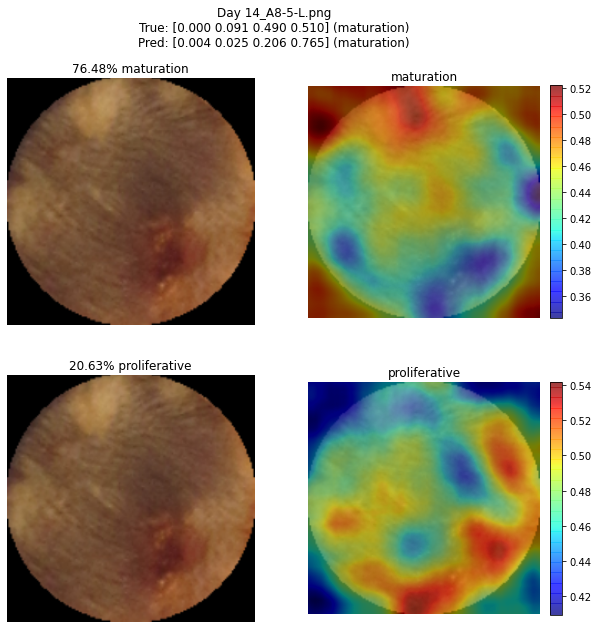

In [ ]:
test_images = ['Day 0_Y8-4-L.png', 'Day 11_Y8-4-L.png', 'Day 4_A8-1-R.png', 'Day 12_A8-1-R.png']
train_images = ['Day 3_Y8-3-L.png','Day 12_Y8-1-L.png', 'Day 6_A8-4-R.png','Day 14_A8-5-L.png']
image_name = train_images[3]
img_t = read_tensor(root_path + 'Circle_Cropped_images/' + image_name)
example(img_t, 2, image_name)

In [ ]:
random.sample(os.listdir(root_path + "Split_images/train"), 4)

['Day 3_Y8-3-L.png',
 'Day 12_Y8-1-L.png',
 'Day 6_A8-4-R.png',
 'Day 14_A8-5-L.png']

# Cleaning Discrete Labels

### Setup

In [206]:
labels_df = pd.read_csv(root_path + 'Updated_Cropped_Images_Wound_Stage_Probabilities.csv', index_col='Image')
labels_df['label'] = labels_df.index.map(lambda x: labels_df.loc[x].argmax())

props = labels_df.index.map(lambda x: re.match('^Day (\d+)_(.+?).png', x).groups())
labels_df['Day'] = props.map(lambda x: int(x[0]))
labels_df['Wound'] = props.map(lambda x: x[1])

labels_df.head()

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 8_A8-4-L.png,0.181818,0.090909,0.545455,0.181818,2,8,A8-4-L
Day 4_A8-3-R.png,0.090909,0.909091,0.000000,0.000000,1,4,A8-3-R
Day 14_Y8-4-L.png,0.000000,0.000000,0.090909,0.909091,3,14,Y8-4-L
Day 7_Y8-4-L.png,0.000000,0.000000,0.454545,0.545455,3,7,Y8-4-L
Day 2_A8-1-L.png,0.181818,0.727273,0.090909,0.000000,1,2,A8-1-L


In [207]:
wounds = labels_df['Wound'].unique()
wounds

array(['A8-4-L', 'A8-3-R', 'Y8-4-L', 'A8-1-L', 'A8-1-R', 'A8-5-L',
       'Y8-3-L', 'Y8-1-R', 'A8-4-R', 'Y8-2-R', 'Y8-3-R', 'A8-5-R',
       'Y8-1-L', 'Y8-2-L', 'A8-3-L', 'Y8-4-R'], dtype=object)

In [208]:
# get all labels for a given wound index
def get_labels_df(wound_index):
    return labels_df[labels_df.Wound == wounds[wound_index]].sort_values('Day')

In [209]:
def show_img(image_name):
    cv2_imshow(cv2.imread(root_path + 'Circle_Cropped_images/' + image_name))

### Inspecting and Modifying LAbels

In [211]:
get_labels_df(0)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_A8-4-L.png,1.000000,0.000000,0.000000,0.000000,0,0,A8-4-L
Day 1_A8-4-L.png,0.900000,0.100000,0.000000,0.000000,0,1,A8-4-L
Day 2_A8-4-L.png,0.800000,0.200000,0.000000,0.000000,0,2,A8-4-L
Day 3_A8-4-L.png,0.100000,0.800000,0.100000,0.000000,1,3,A8-4-L
Day 4_A8-4-L.png,0.100000,0.700000,0.200000,0.000000,1,4,A8-4-L
Day 5_A8-4-L.png,0.000000,0.590000,0.410000,0.000000,1,5,A8-4-L
Day 6_A8-4-L.png,0.200000,0.600000,0.200000,0.000000,1,6,A8-4-L
Day 7_A8-4-L.png,0.200000,0.500000,0.300000,0.000000,1,7,A8-4-L
Day 8_A8-4-L.png,0.181818,0.090909,0.545455,0.181818,2,8,A8-4-L


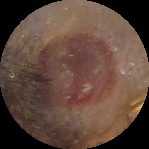

In [212]:
show_img('Day 9_A8-4-L.png')

In [213]:
labels_df.loc['Day 9_A8-4-L.png', 'label'] = 2

In [214]:
get_labels_df(1)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_A8-3-R.png,0.600000,0.400000,0.000000,0.0,0,0,A8-3-R
Day 1_A8-3-R.png,0.800000,0.200000,0.000000,0.0,0,1,A8-3-R
Day 2_A8-3-R.png,0.700000,0.300000,0.000000,0.0,0,2,A8-3-R
Day 3_A8-3-R.png,0.300000,0.600000,0.100000,0.0,1,3,A8-3-R
Day 4_A8-3-R.png,0.090909,0.909091,0.000000,0.0,1,4,A8-3-R
Day 5_A8-3-R.png,0.200000,0.700000,0.100000,0.0,1,5,A8-3-R
Day 6_A8-3-R.png,0.100000,0.800000,0.100000,0.0,1,6,A8-3-R
Day 7_A8-3-R.png,0.000000,0.420000,0.580000,0.0,2,7,A8-3-R
Day 8_A8-3-R.png,0.000000,0.200000,0.800000,0.0,2,8,A8-3-R


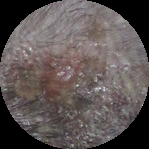

In [215]:
show_img('Day 15_A8-3-R.png')

In [216]:
labels_df.loc['Day 15_A8-3-R.png', 'label'] = 3

In [217]:
get_labels_df(2)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_Y8-4-L.png,1.00,0.00,0.000000,0.000000,0,0,Y8-4-L
Day 1_Y8-4-L.png,0.57,0.43,0.000000,0.000000,0,1,Y8-4-L
Day 2_Y8-4-L.png,0.80,0.20,0.000000,0.000000,0,2,Y8-4-L
Day 3_Y8-4-L.png,0.20,0.80,0.000000,0.000000,1,3,Y8-4-L
Day 4_Y8-4-L.png,0.40,0.50,0.100000,0.000000,1,4,Y8-4-L
Day 5_Y8-4-L.png,0.30,0.50,0.200000,0.000000,1,5,Y8-4-L
Day 6_Y8-4-L.png,0.10,0.30,0.600000,0.000000,2,6,Y8-4-L
Day 7_Y8-4-L.png,0.00,0.00,0.454545,0.545455,3,7,Y8-4-L
Day 8_Y8-4-L.png,0.00,0.00,0.600000,0.400000,2,8,Y8-4-L


In [218]:
labels_df.loc['Day 7_Y8-4-L.png', 'label'] = 2

In [219]:
get_labels_df(3)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_A8-1-L.png,0.600000,0.200000,0.200000,0.000000,0,0,A8-1-L
Day 1_A8-1-L.png,0.900000,0.100000,0.000000,0.000000,0,1,A8-1-L
Day 2_A8-1-L.png,0.181818,0.727273,0.090909,0.000000,1,2,A8-1-L
Day 3_A8-1-L.png,0.300000,0.700000,0.000000,0.000000,1,3,A8-1-L
Day 4_A8-1-L.png,0.100000,0.400000,0.500000,0.000000,2,4,A8-1-L
Day 5_A8-1-L.png,0.000000,0.200000,0.800000,0.000000,2,5,A8-1-L
Day 6_A8-1-L.png,0.200000,0.400000,0.400000,0.000000,1,6,A8-1-L
Day 7_A8-1-L.png,0.300000,0.200000,0.500000,0.000000,2,7,A8-1-L
Day 8_A8-1-L.png,0.300000,0.100000,0.600000,0.000000,2,8,A8-1-L


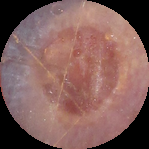

In [220]:
show_img('Day 6_A8-1-L.png')

In [221]:
labels_df.loc['Day 6_A8-1-L.png', 'label'] = 2

In [222]:
get_labels_df(4)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_A8-1-R.png,0.900000,0.100000,0.000000,0.0,0,0,A8-1-R
Day 1_A8-1-R.png,0.100000,0.800000,0.100000,0.0,1,1,A8-1-R
Day 2_A8-1-R.png,0.400000,0.500000,0.100000,0.0,1,2,A8-1-R
Day 3_A8-1-R.png,0.400000,0.500000,0.100000,0.0,1,3,A8-1-R
Day 4_A8-1-R.png,0.363636,0.636364,0.000000,0.0,1,4,A8-1-R
Day 5_A8-1-R.png,0.200000,0.500000,0.300000,0.0,1,5,A8-1-R
Day 6_A8-1-R.png,0.200000,0.700000,0.100000,0.0,1,6,A8-1-R
Day 7_A8-1-R.png,0.100000,0.700000,0.100000,0.1,1,7,A8-1-R
Day 8_A8-1-R.png,0.200000,0.600000,0.200000,0.0,1,8,A8-1-R


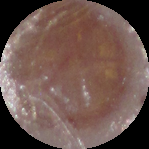

In [223]:
show_img('Day 1_A8-1-R.png')

In [224]:
labels_df.loc['Day 9_A8-1-R.png', 'label'] = 2
labels_df.loc['Day 15_A8-1-R.png', 'label'] = 3

In [225]:
get_labels_df(5)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_A8-5-L.png,0.8,0.200000,0.000000,0.000000,0,0,A8-5-L
Day 1_A8-5-L.png,0.6,0.300000,0.100000,0.000000,0,1,A8-5-L
Day 2_A8-5-L.png,0.9,0.100000,0.000000,0.000000,0,2,A8-5-L
Day 3_A8-5-L.png,0.2,0.800000,0.000000,0.000000,1,3,A8-5-L
Day 4_A8-5-L.png,0.2,0.300000,0.500000,0.000000,2,4,A8-5-L
Day 5_A8-5-L.png,0.1,0.500000,0.400000,0.000000,1,5,A8-5-L
Day 6_A8-5-L.png,0.1,0.500000,0.400000,0.000000,1,6,A8-5-L
Day 7_A8-5-L.png,0.0,0.000000,0.909091,0.090909,2,7,A8-5-L
Day 8_A8-5-L.png,0.0,0.400000,0.600000,0.000000,2,8,A8-5-L


In [226]:
labels_df.loc['Day 4_A8-5-L.png', 'label'] = 1
labels_df.loc['Day 9_A8-5-L.png', 'label'] = 2
labels_df.loc['Day 15_A8-5-L.png', 'label'] = 3

In [227]:
get_labels_df(6)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_Y8-3-L.png,0.727273,0.272727,0.0,0.0,0,0,Y8-3-L
Day 1_Y8-3-L.png,0.700000,0.300000,0.0,0.0,0,1,Y8-3-L
Day 2_Y8-3-L.png,0.700000,0.300000,0.0,0.0,0,2,Y8-3-L
Day 3_Y8-3-L.png,0.400000,0.500000,0.1,0.0,1,3,Y8-3-L
Day 4_Y8-3-L.png,0.300000,0.600000,0.1,0.0,1,4,Y8-3-L
Day 5_Y8-3-L.png,0.200000,0.400000,0.4,0.0,1,5,Y8-3-L
Day 6_Y8-3-L.png,0.100000,0.300000,0.6,0.0,2,6,Y8-3-L
Day 7_Y8-3-L.png,0.000000,0.200000,0.7,0.1,2,7,Y8-3-L
Day 8_Y8-3-L.png,0.000000,0.100000,0.6,0.3,2,8,Y8-3-L


In [228]:
get_labels_df(7)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_Y8-1-R.png,0.8,0.20,0.000000,0.000000,0,0,Y8-1-R
Day 1_Y8-1-R.png,0.7,0.30,0.000000,0.000000,0,1,Y8-1-R
Day 2_Y8-1-R.png,0.7,0.30,0.000000,0.000000,0,2,Y8-1-R
Day 3_Y8-1-R.png,0.4,0.60,0.000000,0.000000,1,3,Y8-1-R
Day 4_Y8-1-R.png,0.2,0.70,0.100000,0.000000,1,4,Y8-1-R
Day 5_Y8-1-R.png,0.1,0.50,0.400000,0.000000,1,5,Y8-1-R
Day 6_Y8-1-R.png,0.0,0.51,0.490000,0.000000,1,6,Y8-1-R
Day 7_Y8-1-R.png,0.0,0.30,0.500000,0.200000,2,7,Y8-1-R
Day 8_Y8-1-R.png,0.0,0.10,0.800000,0.100000,2,8,Y8-1-R


In [229]:
get_labels_df(8)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_A8-4-R.png,1.000000,0.000000,0.000000,0.000000,0,0,A8-4-R
Day 1_A8-4-R.png,0.800000,0.200000,0.000000,0.000000,0,1,A8-4-R
Day 2_A8-4-R.png,0.900000,0.100000,0.000000,0.000000,0,2,A8-4-R
Day 3_A8-4-R.png,0.909091,0.090909,0.000000,0.000000,0,3,A8-4-R
Day 4_A8-4-R.png,0.200000,0.500000,0.300000,0.000000,1,4,A8-4-R
Day 5_A8-4-R.png,0.100000,0.700000,0.200000,0.000000,1,5,A8-4-R
Day 6_A8-4-R.png,0.500000,0.400000,0.100000,0.000000,0,6,A8-4-R
Day 7_A8-4-R.png,0.100000,0.700000,0.200000,0.000000,1,7,A8-4-R
Day 8_A8-4-R.png,0.000000,0.400000,0.500000,0.100000,2,8,A8-4-R


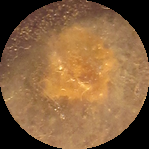

In [230]:
show_img('Day 14_A8-4-R.png')

In [231]:
labels_df.loc['Day 6_A8-4-R.png', 'label'] = 1

In [232]:
get_labels_df(9)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_Y8-2-R.png,1.000000,0.000000,0.000000,0.0,0,0,Y8-2-R
Day 1_Y8-2-R.png,0.800000,0.200000,0.000000,0.0,0,1,Y8-2-R
Day 2_Y8-2-R.png,0.400000,0.600000,0.000000,0.0,1,2,Y8-2-R
Day 3_Y8-2-R.png,0.600000,0.300000,0.100000,0.0,0,3,Y8-2-R
Day 4_Y8-2-R.png,0.181818,0.545455,0.272727,0.0,1,4,Y8-2-R
Day 5_Y8-2-R.png,0.000000,0.200000,0.800000,0.0,2,5,Y8-2-R
Day 6_Y8-2-R.png,0.000000,0.100000,0.700000,0.2,2,6,Y8-2-R
Day 7_Y8-2-R.png,0.000000,0.000000,0.800000,0.2,2,7,Y8-2-R
Day 8_Y8-2-R.png,0.000000,0.000000,0.700000,0.3,2,8,Y8-2-R


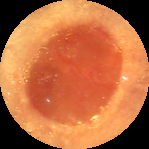

In [233]:
show_img('Day 2_Y8-2-R.png')

In [234]:
labels_df.loc['Day 3_Y8-2-R.png', 'label'] = 1

In [235]:
get_labels_df(10)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_Y8-3-R.png,1.000000,0.000000,0.000000,0.000000,0,0,Y8-3-R
Day 1_Y8-3-R.png,0.800000,0.200000,0.000000,0.000000,0,1,Y8-3-R
Day 2_Y8-3-R.png,0.900000,0.100000,0.000000,0.000000,0,2,Y8-3-R
Day 3_Y8-3-R.png,0.636364,0.272727,0.090909,0.000000,0,3,Y8-3-R
Day 4_Y8-3-R.png,0.600000,0.400000,0.000000,0.000000,0,4,Y8-3-R
Day 5_Y8-3-R.png,0.100000,0.700000,0.200000,0.000000,1,5,Y8-3-R
Day 6_Y8-3-R.png,0.090909,0.181818,0.727273,0.000000,2,6,Y8-3-R
Day 7_Y8-3-R.png,0.100000,0.100000,0.700000,0.100000,2,7,Y8-3-R
Day 8_Y8-3-R.png,0.000000,0.000000,0.600000,0.400000,2,8,Y8-3-R


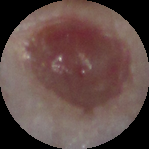

In [236]:
show_img('Day 4_Y8-3-R.png')

In [237]:
get_labels_df(11)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_A8-5-R.png,0.800000,0.200000,0.000000,0.000000,0,0,A8-5-R
Day 1_A8-5-R.png,0.545455,0.454545,0.000000,0.000000,0,1,A8-5-R
Day 2_A8-5-R.png,0.600000,0.400000,0.000000,0.000000,0,2,A8-5-R
Day 3_A8-5-R.png,0.200000,0.600000,0.200000,0.000000,1,3,A8-5-R
Day 4_A8-5-R.png,0.000000,0.363636,0.636364,0.000000,2,4,A8-5-R
Day 5_A8-5-R.png,0.000000,0.500000,0.500000,0.000000,1,5,A8-5-R
Day 6_A8-5-R.png,0.100000,0.400000,0.500000,0.000000,2,6,A8-5-R
Day 7_A8-5-R.png,0.000000,0.400000,0.600000,0.000000,2,7,A8-5-R
Day 8_A8-5-R.png,0.100000,0.100000,0.700000,0.100000,2,8,A8-5-R


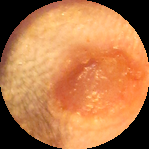

In [238]:
show_img('Day 5_A8-5-R.png')

In [239]:
labels_df.loc['Day 5_A8-5-R.png', 'label'] = 2
labels_df.loc['Day 10_A8-5-R.png', 'label'] = 3

In [240]:
get_labels_df(12)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_Y8-1-L.png,0.727273,0.272727,0.000000,0.000000,0,0,Y8-1-L
Day 1_Y8-1-L.png,0.700000,0.300000,0.000000,0.000000,0,1,Y8-1-L
Day 2_Y8-1-L.png,0.800000,0.200000,0.000000,0.000000,0,2,Y8-1-L
Day 3_Y8-1-L.png,0.400000,0.500000,0.100000,0.000000,1,3,Y8-1-L
Day 4_Y8-1-L.png,0.300000,0.500000,0.200000,0.000000,1,4,Y8-1-L
Day 5_Y8-1-L.png,0.363636,0.545455,0.090909,0.000000,1,5,Y8-1-L
Day 6_Y8-1-L.png,0.000000,0.600000,0.400000,0.000000,1,6,Y8-1-L
Day 7_Y8-1-L.png,0.100000,0.200000,0.700000,0.000000,2,7,Y8-1-L
Day 8_Y8-1-L.png,0.000000,0.100000,0.900000,0.000000,2,8,Y8-1-L


In [241]:
get_labels_df(13)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_Y8-2-L.png,0.900000,0.100000,0.000000,0.000000,0,0,Y8-2-L
Day 1_Y8-2-L.png,1.000000,0.000000,0.000000,0.000000,0,1,Y8-2-L
Day 2_Y8-2-L.png,0.727273,0.272727,0.000000,0.000000,0,2,Y8-2-L
Day 3_Y8-2-L.png,0.800000,0.200000,0.000000,0.000000,0,3,Y8-2-L
Day 4_Y8-2-L.png,0.700000,0.300000,0.000000,0.000000,0,4,Y8-2-L
Day 5_Y8-2-L.png,0.100000,0.400000,0.500000,0.000000,2,5,Y8-2-L
Day 6_Y8-2-L.png,0.100000,0.600000,0.300000,0.000000,1,6,Y8-2-L
Day 7_Y8-2-L.png,0.090909,0.545455,0.363636,0.000000,1,7,Y8-2-L
Day 8_Y8-2-L.png,0.100000,0.400000,0.500000,0.000000,2,8,Y8-2-L


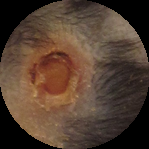

In [242]:
show_img('Day 9_Y8-2-L.png')

In [243]:
labels_df.loc['Day 5_Y8-2-L.png', 'label'] = 1
labels_df.loc['Day 9_Y8-2-L.png', 'label'] = 2

In [244]:
get_labels_df(14)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_A8-3-L.png,0.700000,0.200000,0.100000,0.0,0,0,A8-3-L
Day 1_A8-3-L.png,0.800000,0.200000,0.000000,0.0,0,1,A8-3-L
Day 2_A8-3-L.png,0.545455,0.454545,0.000000,0.0,0,2,A8-3-L
Day 3_A8-3-L.png,0.200000,0.700000,0.000000,0.1,1,3,A8-3-L
Day 4_A8-3-L.png,0.300000,0.600000,0.100000,0.0,1,4,A8-3-L
Day 5_A8-3-L.png,0.200000,0.700000,0.100000,0.0,1,5,A8-3-L
Day 6_A8-3-L.png,0.200000,0.600000,0.200000,0.0,1,6,A8-3-L
Day 7_A8-3-L.png,0.100000,0.100000,0.800000,0.0,2,7,A8-3-L
Day 8_A8-3-L.png,0.000000,0.600000,0.400000,0.0,1,8,A8-3-L


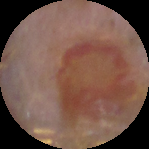

In [245]:
show_img('Day 8_A8-3-L.png')

In [246]:
labels_df.loc['Day 8_A8-3-L.png', 'label'] = 2

In [247]:
get_labels_df(15)

,hemostasis,inflammatory,proliferative,maturation,label,Day,Wound
Image,,,,,,,
Day 0_Y8-4-R.png,1.000000,0.000000,0.000000,0.0,0,0,Y8-4-R
Day 1_Y8-4-R.png,0.181818,0.272727,0.545455,0.0,2,1,Y8-4-R
Day 2_Y8-4-R.png,0.300000,0.700000,0.000000,0.0,1,2,Y8-4-R
Day 3_Y8-4-R.png,0.300000,0.700000,0.000000,0.0,1,3,Y8-4-R
Day 4_Y8-4-R.png,0.090909,0.363636,0.545455,0.0,2,4,Y8-4-R
Day 5_Y8-4-R.png,0.000000,0.200000,0.800000,0.0,2,5,Y8-4-R
Day 6_Y8-4-R.png,0.000000,0.300000,0.700000,0.0,2,6,Y8-4-R
Day 7_Y8-4-R.png,0.000000,0.000000,0.600000,0.4,2,7,Y8-4-R
Day 8_Y8-4-R.png,0.100000,0.000000,0.800000,0.1,2,8,Y8-4-R


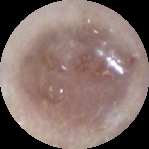

In [248]:
show_img('Day 1_Y8-4-R.png')

In [249]:
labels_df.loc['Day 1_Y8-4-R.png', 'label'] = 1

### Review and Saving

In [250]:
# ensure all labels are non-decreasing as day increases
# shouldn't print anything
for wound_ind in range(len(wounds)):
    labels = get_labels_df(wound_ind)['label']
    prev_label = labels[0]
    for label_ind in range(1, len(labels)):
        if labels[label_ind] < prev_label:
            print(labels.index[label_ind])
        prev_label = labels[label_ind]

In [251]:
cleaned_df = labels_df[['hemostasis','inflammatory','proliferative','maturation','label']]
cleaned_df.head()

,hemostasis,inflammatory,proliferative,maturation,label
Image,,,,,
Day 8_A8-4-L.png,0.181818,0.090909,0.545455,0.181818,2
Day 4_A8-3-R.png,0.090909,0.909091,0.000000,0.000000,1
Day 14_Y8-4-L.png,0.000000,0.000000,0.090909,0.909091,3
Day 7_Y8-4-L.png,0.000000,0.000000,0.454545,0.545455,2
Day 2_A8-1-L.png,0.181818,0.727273,0.090909,0.000000,1


In [252]:
cleaned_df.to_csv(root_path + 'Cleaned_Wound_Stage_Labels.csv')